# Notebook for Google Colab


This is a demo for DQN (Deep Q Networks).

Task Introduction:

We show the agent a picture with one to three foods in it.  We will train until the robot can correctly answer the number of food in the picture.

##Introduction

In today's code, the DQN introduced is based on the Q-learning method. Q-learning is a value-based method. In the value-based method, we do not directly learn policy. Our purpose is to learn a critic. The critic does not directly take action. It wants to evaluate how much the current behavior is good (or bad).


For example, there is a critic called state value function $V^\pi(s)$, assuming that the current actor is $\pi$, we use this actor $\pi$ to interact with the environment. Suppose $\pi$ sees a specific state $s$; how big will the accumulated reward be. What needs to be emphasized here is that the critic is bound to the actor; that is to say, the critic cannot directly measure the quality of a state. The critic measures that when a state is given, assuming that the interacting actor is $\pi$, how much reward can we get. That is to say, even in the same state, our actor $\pi$ is different, and the rewards we get are also different. That is to say, the size of critic $V^\pi(s)$ is determined by actor $\pi$ and state $s$.


Regarding how to estimate $V^\pi(s)$, there are usually two methods, Monte-Carlo (MC) method, and the Temporal difference (TD) method. The MC method is based on repeated experiments, which is to let the actor interact with the environment, and the critic calculates the cumulated reward $G$. Since it is usually impossible to traverse all states (because the traversal space is large), critic $V^\pi$ is actually a neural network. The input of the neural network is state $s_i$, and the output is the accumulated reward $G_i$. In the MC method, we need to calculate the accumulated reward $G$ every time, which means we need to reach the last state. But sometimes, the state is very long, and the MC method will have problems. The TD method does not need to reach the end of the state because TD is trained by $V^\pi(s_t)-V^\pi(s_{t-1}) = r$. Today the TD method is more commonly used than MC.

Another different Critic is Q-function, also known as the value function $Q^\pi(s,a)$ of state-action. The input of the critic mentioned earlier is state, and the accumulated reward is calculated according to the state. The input of $Q^\pi(s,a)$ is a pair of state and action. That is to say, actor $\pi$ takes a certain action $a$ in a certain state $s$, how much is the accumulated reward obtained.

## Download food images

In [ ]:
!wget --no-check-certificate https://tslab2.ip.titech.ac.jp/spolacq/data.zip
!unzip -q data.zip

Stable Baselines3 (SB3) is an improved version of the reinforcement learning algorithm implementation set provided by OpenAI.

We use it in this demo.

In [ ]:
%pip install stable-baselines3

In [31]:
from glob import glob
import os
import random
import sys
from typing import Tuple

from google.colab import drive
import gym
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from stable_baselines3.dqn.dqn import DQN
from stable_baselines3.common.evaluation import evaluate_policy
import warnings
warnings.filterwarnings("ignore")

## Environment



We need to define the environment in this RL task. 

The environment provides action space and state space (observation space) as parameters to construct our policy network.

Also the environment could help interactively train our model. At each step, the agent gets the observation from the environment, calculates, and selects the action.

In [13]:
class Environment(gym.Env):
    """
    Args:
        food (str): one of foods: "apple", "banana", "carrot", "cherry", "cucumber",
        "egg", "eggplant", "green_pepper", "hyacinth_bean", "kiwi_fruit",
        "lemon", "onion", "orange", "potato", "sliced_bread", "small_cabbage",
        "strawberry", "sweet_potato", "tomato", and "white_radish".
        split (str): dataset split. "train" or "test".
    """
    def __init__(self, food: str = "apple", split: str = "train"):
        super().__init__()
        self.action_space = gym.spaces.Discrete(3)  #number of foods {0, 1, 2}
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(224, 224, 3), dtype=np.uint8)  # RGB image

        assert split in ["train", "test"], "dataset split must be 'train' or 'test'"
        
        self.dataset = []
        for num_of_foods in range(1, 4):
            paths = glob(f"data/dataset/{food}/{split}_number{num_of_foods}/group*_*.jpg")
            for path in paths:
                image = Image.open(path)
                image = np.array(image)
                
                self.dataset.append((image, num_of_foods-1))

        self.reset()
    
    def reset(self) -> np.ndarray:
        state, num_of_foods = random.choice(self.dataset)
        self.correct_answer = num_of_foods
        return state
    
    def step(self, action) -> Tuple[np.ndarray, int, bool, dict]:

        if action == self.correct_answer:
            reward = 1
        else:
            reward = 0
        
        # Update state
        new_state, num_of_foods = random.choice(self.dataset)
        self.correct_answer = num_of_foods

        return new_state, reward, True, dict()

In [ ]:
env = Environment(split="train")

agent = DQN(
    "CnnPolicy",
    env,
    buffer_size=100,
    learning_starts=0,
    verbose=1, #verbose=1 means printing information during training, verbose=0 means these information will not be displayed
    )

### initialized agent

Agent's answer: 3
Reward: 0


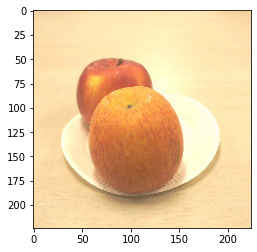

In [15]:
# Initialize state
state = env.reset()
plt.imshow(state)

# Agent gets an environment state and returns a decided action
action, _ = agent.predict(state, deterministic=True)
print(f"Agent's answer: {action+1}")

# Environment gets an action from the agent, proceeds the time step,
# and returns the new state and reward etc.
state, reward, done, info = env.step(action)
print(f"Reward: {reward}")

In [ ]:
agent.learn(total_timesteps=2000)

## Test agent

In [17]:
test_env = Environment(split="test")

### Run the following cell several times

Agent's answer: 2
Reward: 1


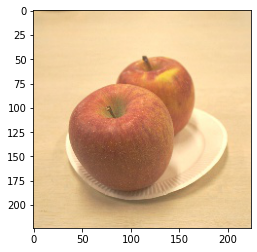

In [26]:
# Initialize state
state = test_env.reset()
plt.imshow(state)

# Agent gets an environment state and returns a decided action
action, _ = agent.predict(state, deterministic=True)
print(f"Agent's answer: {action+1}")

# Environment gets an action from the agent, proceeds the time step,
# and returns the new state and reward etc.
state, reward, done, info = test_env.step(action)
print(f"Reward: {reward}")

###Evaluation

In [52]:
#evaluate_policy() returns the mean and std of the rewards of the our trained model

mean_reward, std_reward = evaluate_policy(agent, env, n_eval_episodes=20, render=False)
env.close()
print(f"Mean reward: {mean_reward}")
print(f"Std reward: {std_reward}")


Mean reward: 1.0
Std reward: 0.0
